<a href="https://colab.research.google.com/github/mohitraosatya/neuromorphic_Audio_Analysis./blob/main/homeostatic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install -q torchaudio spikingjelly matplotlib librosa ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.0 MB/s eta 0:00:00


In [ ]:
# Install required libraries (if not already installed)
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib librosa --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 18.6 MB/s eta 0:00:00
=== Homeostatic Cochlea Demo ===


100%|██████████| 427k/427k [00:00<00:00, 13.7MB/s]


Baseline CV: 18.61%
Adaptive CV: 8.62%
Reduction in CV: 53.66%


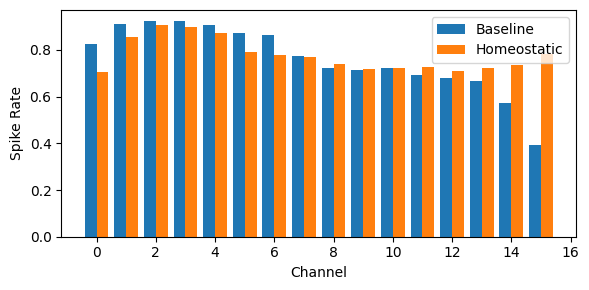

In [1]:
# === 1) Install dependencies (run once) ===
!pip install --quiet torch torchvision torchaudio matplotlib

# === 2) Imports ===
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.datasets import YESNO
from torch.utils.data import DataLoader

# === 3) Homeostatic Cochlea Demo ===
def demo_homeostatic():
    wav, sr = torchaudio.load(torchaudio.utils.download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav"))
    wav = wav.mean(dim=0, keepdim=True)
    wav = T.Resample(orig_freq=sr, new_freq=16000)(wav)

    mel = T.MelSpectrogram(sample_rate=16000, n_mels=16)(wav)
    db  = T.AmplitudeToDB()(mel).squeeze(0).numpy()  # [16, frames]

    norm = (db - db.min())/(db.max() - db.min())

    # Baseline
    thr0 = 0.5
    spikes0 = norm > thr0
    rates0  = spikes0.mean(axis=1)
    cv0     = np.std(rates0)/rates0.mean()*100

    # Homeostatic one-step
    target = rates0.mean()
    thr1   = thr0 + 0.5*(rates0 - target)
    thr1   = np.clip(thr1, 0, 1)
    spikes1= norm > thr1[:,None]
    rates1 = spikes1.mean(axis=1)
    cv1    = np.std(rates1)/rates1.mean()*100

    print(f"Baseline CV: {cv0:.2f}%")
    print(f"Adaptive CV: {cv1:.2f}%")
    print(f"Reduction in CV: {(cv0-cv1)/cv0*100:.2f}%")

    ch = np.arange(len(rates0))
    plt.figure(figsize=(6,3))
    plt.bar(ch-0.2, rates0, width=0.4, label="Baseline")
    plt.bar(ch+0.2, rates1, width=0.4, label="Homeostatic")
    plt.xlabel("Channel"); plt.ylabel("Spike Rate")
    plt.legend(); plt.tight_layout(); plt.show()

# === 4) SNN classifier (average over channels → Linear(n_frames,2)) ===
class SimpleSNN(nn.Module):
    def __init__(self, in_features, out_features=2): # Set default out_features to 2
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)  # Use in_features for input size
    def forward(self, x):
        # x: [batch, channels, frames]
        x = x.mean(dim=1)            # → [batch, frames]
        return F.log_softmax(self.fc(x), dim=1)

# define mel32 and db32
mel32 = T.MelSpectrogram(sample_rate=16000, n_mels=32)
db32 = T.AmplitudeToDB()

def baseline_pipeline(wav, sr, model=None):
    if sr != 16000:
        wav = T.Resample(orig_freq=sr, new_freq=16000)(wav)
    m = mel32(wav)               # [1,32,frames]
    d = db32(m).squeeze(0)       # [32,frames]
    thr = d.mean()
    spikes = (d > thr).float().unsqueeze(0)  # [1,32,frames]
    # sum over mel channels to get a shape of [batch_size, n_frames]
    spikes = spikes.sum(dim=1) # [1, frames]
    n_frames = spikes.size(1)
    if model is None:
        model = SimpleSNN(n_frames) # Pass n_frames as in_features to SimpleSNN
    return model, model(spikes)


def adaptive_pipeline(wav, sr, model=None):
    if sr != 16000:
        wav = T.Resample(orig_freq=sr, new_freq=16000)(wav)
    m = mel32(wav)
    d = db32(m).squeeze(0)
    # Homeostatic threshold
    rates = (d > d.mean()).float().mean(dim=1)   # [32]
    thr   = d.mean() + 0.5*(rates.mean()-rates)[:,None]
    thr   = thr.clamp(d.min(), d.max())
    spikes= (d > thr).float().unsqueeze(0)
    # sum over mel channels to get a shape of [batch_size, n_frames]
    spikes = spikes.sum(dim=1) # [1, frames]
    n_frames = spikes.size(1)
    if model is None:
        model = SimpleSNN(n_frames) # Pass n_frames as in_features to SimpleSNN
    return model, model(spikes)


# === 7) Run both ===
if __name__=="__main__":
    print("=== Homeostatic Cochlea Demo ===")
    demo_homeostatic()
